In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model
from sklearn.model_selection import train_test_split
import re
import nltk 
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download('punkt')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# warning library
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read the csv file

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ebay_reviews.csv")

In [ ]:
data.head()

,category,review title,review content,rating
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5


In [ ]:
# the columns 
data.columns

Index(['category', 'review title', 'review content', 'rating'], dtype='object')

Drop unnecessary Columns

In [ ]:
data = data.drop(columns=["category","review title"])
data.head()

,review content,rating
0,This gaming headset ticks all the boxes # look...,5
1,"Easy setup, rated for 6 hours battery but mine...",3
2,I originally bought this wireless headset for ...,5
3,"This is my 2nd Mezumi headset, It kills the fi...",5
4,This is probably the best headset I've purchas...,5


In [ ]:
# we are looking at the size of our data.
data.shape

(44756, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44756 entries, 0 to 44755
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review content  44756 non-null  object
 1   rating          44756 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 699.4+ KB


In [ ]:
# statistical summary of our data
data.describe()

,rating
count,44756.000000
mean,4.656337
std,0.847600
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


### Converting the rating to Positive or Negative

In [ ]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['rating'] == 1 or row['rating']  == 2 :
        val = 'Negative'
    elif row['rating'] == 3:
        val = 'Neutral'
    elif row['rating'] == 4 or row['rating'] == 5  :
        val = 'Positive'
    else:
        val = -1
    return val

### Applying the function in our new column

In [ ]:
data['sentiment'] = data.apply(f, axis=1)
data.head()

,review content,rating,sentiment
0,This gaming headset ticks all the boxes # look...,5,Positive
1,"Easy setup, rated for 6 hours battery but mine...",3,Neutral
2,I originally bought this wireless headset for ...,5,Positive
3,"This is my 2nd Mezumi headset, It kills the fi...",5,Positive
4,This is probably the best headset I've purchas...,5,Positive


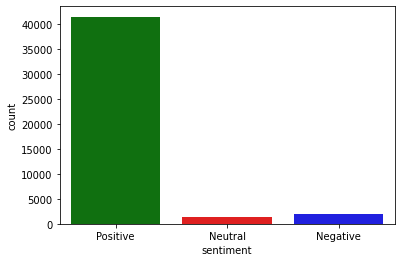

Positive    41442
Negative     1942
Neutral      1372
Name: sentiment, dtype: int64


In [ ]:
sns.countplot(data["sentiment"], palette = ["green","red","blue"])
plt.show()
print(data.sentiment.value_counts())

In [ ]:
data.head(20)

,review content,rating,sentiment
0,This gaming headset ticks all the boxes # look...,5,Positive
1,"Easy setup, rated for 6 hours battery but mine...",3,Neutral
2,I originally bought this wireless headset for ...,5,Positive
3,"This is my 2nd Mezumi headset, It kills the fi...",5,Positive
4,This is probably the best headset I've purchas...,5,Positive
5,This headsert is great for the value! I recent...,5,Positive
6,"Happy with product , as described",4,Positive
7,Verified purchase: Yes | Condition: new | Sol...,5,Positive
8,"All good, product as described",5,Positive
9,"no issues, good distance on blutooth, clear au...",5,Positive


### Removing Punctuation and Brackets and etc.

In [ ]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('english')
#stop_word_list

In [ ]:
data['review content'] = data['review content'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review content'] = data['review content'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

data['review content'] = data['review content'].apply(lambda x: x.lower())

data['review content'] = data['review content'].apply(lambda x: x.strip())

"""
I closed the stopword process because it took a long time.
If you want, you can try opening the codes in the comment line.
"""
#def token(values):
   # words = nltk.tokenize.word_tokenize(values)
    #filtered_words = [word for word in words if word not in set(stopwords.words("english"))]
    #not_stopword_doc = " ".join(filtered_words)
    #return not_stopword_doc
#data['review content'] = data['review content'].apply(lambda x: token(x))

'\nI closed the stopword process because it took a long time.\nIf you want, you can try opening the codes in the comment line.\n'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
Vectorizer = CountVectorizer()
Model = LogisticRegression(max_iter = 4000)

x = data['review content']
y = data['sentiment']
y.value_counts()

Positive    41442
Negative     1942
Neutral      1372
Name: sentiment, dtype: int64

In [ ]:
   # Happy with product , as described
   

### Applying Random Under Sampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
rus = RandomUnderSampler()
y = np.array(y)
x = np.array(x)
y = np.reshape(y, (-1,1))
x = np.reshape(x, (-1,1))
x_r, y_r = rus.fit_resample(x, y)
print(len(y_r))

4116


### Train Test Split the data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_r,y_r)
x_test = x_test.reshape(-1)
x_train = Vectorizer.fit_transform(x_train.reshape(-1))
x_test = Vectorizer.transform(x_test)
Model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
result = Model.predict(x_test)
print(confusion_matrix(y_test, result))

[[216  68  49]
 [ 88 176  93]
 [ 16  64 259]]


In [ ]:
accuracy = accuracy_score(y_test, result)
print(accuracy)

0.6326530612244898


### Test the Model

In [ ]:
pred1 = Model.predict(Vectorizer.transform(["Do not buy it. Horrible product"]))
pred2 = Model.predict(Vectorizer.transform(["This is probably the best thing i have ever bought"]))
pred3 = Model.predict(Vectorizer.transform(["It works fine! Thank you!"]))
pred4 = Model.predict(Vectorizer.transform(["Many disadvantages, i do not recommend it"]))
pred5 = Model.predict(Vectorizer.transform(["My delivery is 2 months delayed. Pure lack of profissionalism"]))
pred6 = Model.predict(Vectorizer.transform(["Excellent product!"]))

print(pred1, pred2, pred3, pred4, pred5, pred6)

['Negative'] ['Positive'] ['Positive'] ['Negative'] ['Neutral'] ['Positive']


### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
import pickle
import seaborn as sns

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train , y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
pred = mnb.predict(x_test)

In [ ]:
print(accuracy_score(y_test , pred))

0.6365403304178814


In [ ]:
print(confusion_matrix(y_test , pred))


[[705 134]
 [148 670]]


In [ ]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

    Negative       0.70      0.58      0.63       333
     Neutral       0.54      0.68      0.60       357
    Positive       0.73      0.65      0.69       339

    accuracy                           0.64      1029
   macro avg       0.66      0.64      0.64      1029
weighted avg       0.65      0.64      0.64      1029



In [ ]:
pd.DataFrame(np.c_[y_test , pred] , columns=["Actual" , "Predicted"])

,Actual,Predicted
0,Positive,Positive
1,Neutral,Neutral
2,Neutral,Neutral
3,Positive,Neutral
4,Neutral,Neutral
...,...,...
1024,Positive,Positive
1025,Positive,Positive
1026,Negative,Negative
1027,Neutral,Neutral


### Save the Pickel file

In [ ]:
import pickle
pickle.dump(Vectorizer, open("count-Vectorizer.pkl" , "wb"))
pickle.dump(Model, open("Ebay_Review_Classification.pkl" , "wb"))


### Load the pickle file

In [ ]:
save_cv = pickle.load(open('count-Vectorizer.pkl','rb'))
model = pickle.load(open('Ebay_Review_Classification.pkl','rb'))

### Test the model

In [ ]:
def test_model(sentence):
    sen = save_cv.transform([sentence]).toarray()
    res = model.predict(sen)[0]
    if res == 'Positive':
        return 'Positive review'
    elif res == 'Neutral':
        return 'Neutral review'    
    else:
        return 'Negative review'

In [ ]:
sen = 'didnt work recieved bought ps4 stayed put til gave son birthday excitement didnt work blue light stayed'
res = test_model(sen)
print(res)

Negative review


In [ ]:
sen = 'It works fine! Thank you!'
res = test_model(sen)
print(res)

Positive review


In [ ]:
sen = 'Do not buy it. Horrible product'
res = test_model(sen)
print(res)

Negative review


In [ ]:
sen = 'Came with the original xbox controller box all smashed up. No padding nothing. Damaged all the way......'
res = test_model(sen)
print(res)

Negative review


In [ ]:
sen = 'My delivery is 2 months delayed. Pure lack of profissionalism'
res = test_model(sen)
print(res)

Neutral review
